# Time series

Make some time series plots to start exploring the data. 

In [2]:
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
import contextily as ctx
import scipy.stats
import scipy.interpolate
import rasterio as rio
import xarray 
import rioxarray

In [9]:
hls = pd.read_csv('data/results_hls_sentinel.csv',
            index_col='meta.native-id')

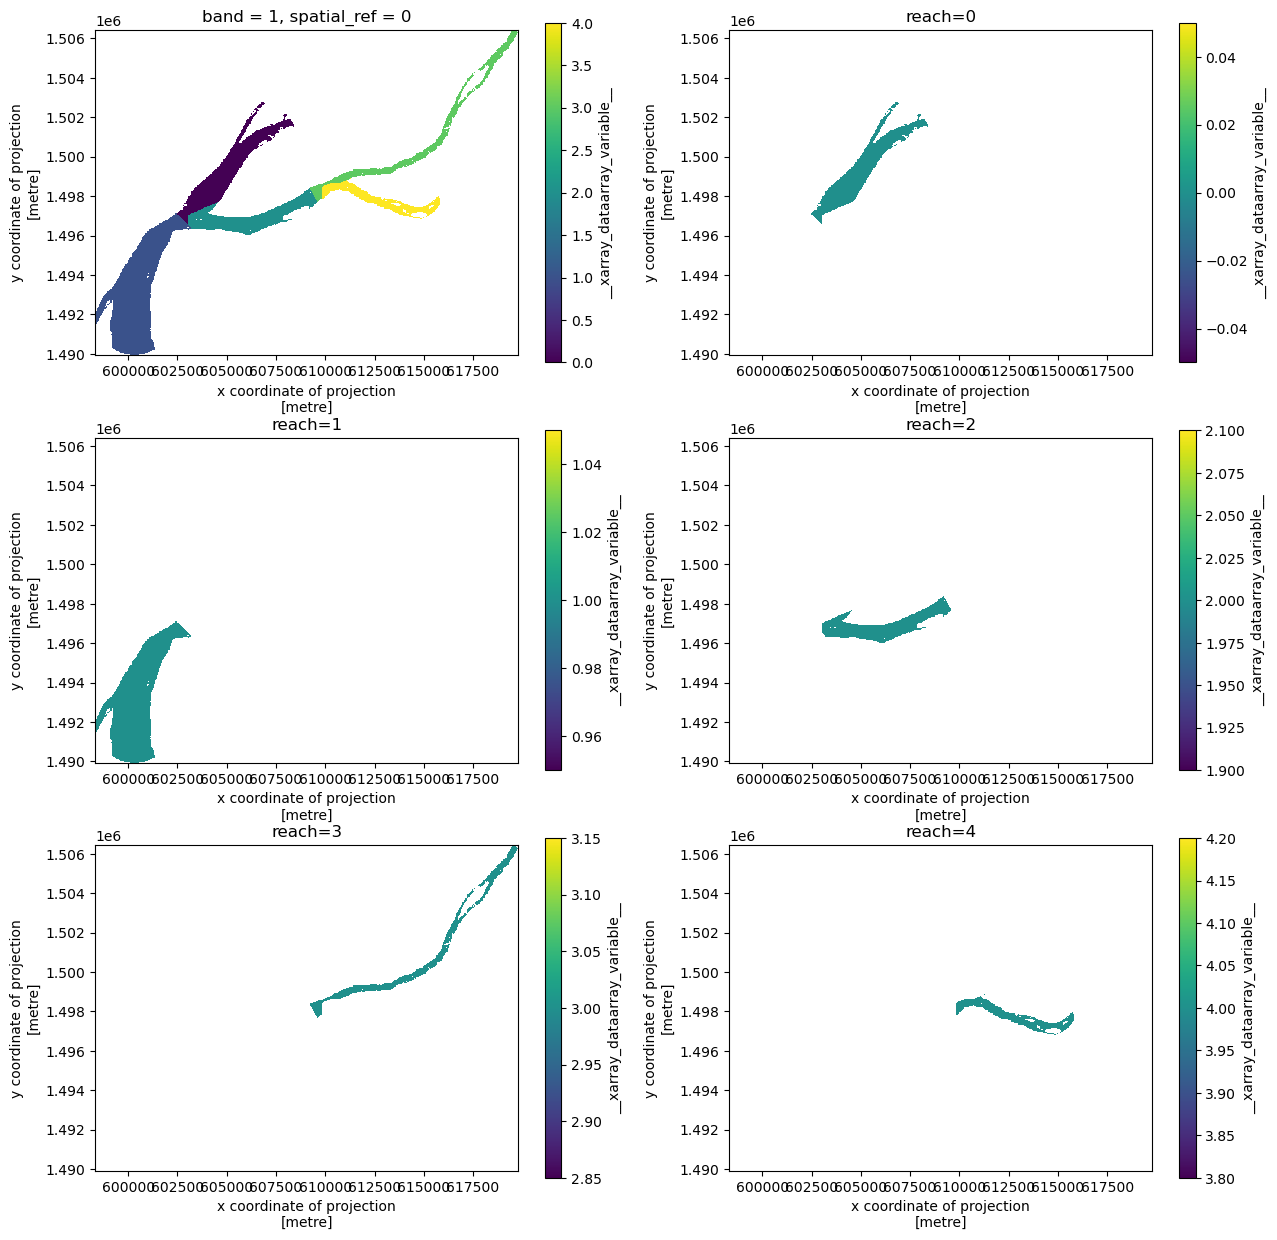

In [74]:
reach_mask = rioxarray.open_rasterio('data/external/river_reach_mask.nc', masked=True).squeeze()
reach_mask = reach_mask.rio.write_crs('EPSG:32648')
fig, ax = plt.subplots(3, 2, figsize=(15,15))

reach_mask.plot.imshow(ax=ax[0,0])
reach_mask.where(reach_mask == 0).plot.imshow(ax=ax[0,1])
ax[0,1].set_title('reach=0')
reach_mask.where(reach_mask == 1).plot.imshow(ax=ax[1,0])
ax[1,0].set_title('reach=1')
reach_mask.where(reach_mask == 2).plot.imshow(ax=ax[1,1])
ax[1,1].set_title('reach=2')
reach_mask.where(reach_mask == 3).plot.imshow(ax=ax[2,0])
ax[2,0].set_title('reach=3')
reach_mask.where(reach_mask == 4).plot.imshow(ax=ax[2,1])
ax[2,1].set_title('reach=4');

for ai in ax: 
    for aj in ai: 
        aj.set_aspect('equal')

In [21]:
# remove landsat
# hls = hls.loc[~hls['platform'].isin(['LANDSAT-8', 'LANDSAT-9'])]

In [10]:
# name reaches
reach_dict = {0: 'kscs', 1: 'sts', 2: '3sb', 3: 'skg', 4: 'ssn'}
hls['reach_name'] = [reach_dict[r] for r in hls['reach']]

In [11]:
# remove dates with 
# reflectance values > 2000
hls = hls.loc[hls['red'] < 2000]

In [12]:
hls['date'] = [datetime.date(d) for d in pd.to_datetime(hls['start_time'])]

In [7]:
# scale factor
hls.loc[:, ['red', 'green', 'nir']] = hls.loc[:, ['red', 'green', 'nir']]  * 0.0001

In [8]:
hls

,Unnamed: 0,platform,tile,start_time,end_time,reach,red,green,nir,ndti,ndci,qc_fail_pixels,total_pixels,reach_name,date
meta.native-id,,,,,,,,,,,,,,,
HLS.S30.T48PWA.2017211T031541.v2.0,5,Sentinel-2A,PWA,2017-07-30T03:32:09.980Z,2017-07-30T03:32:09.980Z,0,0.17590,0.1287,0.16770,0.156527,-0.022204,1689.0,7421.0,kscs,2017-07-30
HLS.S30.T48PXA.2017211T031541.v2.0,6,Sentinel-2A,PXA,2017-07-30T03:32:09.980Z,2017-07-30T03:32:09.980Z,0,0.17790,0.1310,0.16950,0.153087,-0.022835,1575.0,7421.0,kscs,2017-07-30
HLS.S30.T48PWV.2017211T031541.v2.0,7,Sentinel-2A,PWV,2017-07-30T03:32:09.980Z,2017-07-30T03:32:09.980Z,0,0.18740,0.1378,0.17880,0.153396,-0.023974,2559.0,4614.0,kscs,2017-07-30
HLS.S30.T48PXV.2017211T031541.v2.0,8,Sentinel-2A,PXV,2017-07-30T03:32:09.980Z,2017-07-30T03:32:09.980Z,0,0.18950,0.1401,0.18100,0.150961,-0.021535,2567.0,4614.0,kscs,2017-07-30
HLS.S30.T48PXV.2017226T031539.v2.0,16,Sentinel-2B,PXV,2017-08-14T03:32:09.590Z,2017-08-14T03:32:09.590Z,0,0.17310,0.1359,0.15750,0.114062,-0.046019,3352.0,4614.0,kscs,2017-08-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HLS.S30.T48PXA.2024050T031759.v2.0,8293,Sentinel-2B,PXA,2024-02-19T03:34:15.022Z,2024-02-19T03:34:15.022Z,4,0.02955,0.0452,0.01370,-0.210248,-0.335913,2916.0,3180.0,ssn,2024-02-19
HLS.S30.T48PXA.2024055T031721.v2.0,8297,Sentinel-2A,PXA,2024-02-24T03:34:12.408Z,2024-02-24T03:34:12.408Z,4,0.03600,0.0558,0.02440,-0.214570,-0.202240,0.0,3180.0,ssn,2024-02-24
HLS.S30.T48PXV.2024055T031721.v2.0,8299,Sentinel-2A,PXV,2024-02-24T03:34:27.021Z,2024-02-24T03:34:27.021Z,4,0.03560,0.0564,0.02370,-0.220191,-0.207993,0.0,3180.0,ssn,2024-02-24


In [235]:
# aggregate by date

# use a weighted mean
# weighted by number of valid pixels
# add column for number of valid pixels
hls['valid_pixels'] = hls['total_pixels'] - hls['qc_fail_pixels'] 

def weighted_mean(df, col, weights_col = 'valid_pixels', threshold = 3000): 
    total_weights = df[weights_col].sum()
    if (total_weights > threshold):
        weight = df[col] * df[weights_col] / total_weights
        return(weight.sum())
    else: 
        return(np.nan)

red_mean = hls.groupby(['date', 'reach_name']).apply(weighted_mean, 'red')
green_mean = hls.groupby(['date', 'reach_name']).apply(weighted_mean, 'green')
nir_mean = hls.groupby(['date', 'reach_name']).apply(weighted_mean, 'nir')
ndti_mean = hls.groupby(['date', 'reach_name']).apply(weighted_mean, 'ndti')
ndci_mean = hls.groupby(['date', 'reach_name']).apply(weighted_mean, 'ndci')


In [236]:
hls_agg = pd.DataFrame({'red': red_mean, 
              'green': green_mean,
              'nir': nir_mean, 
              'ndti': ndti_mean, 
              'ndci': ndci_mean}).reset_index()

In [237]:
# Calculate rolling average for plotting
# Create list of evenly spaced dates
dates = pd.date_range(
    start=min(hls['date']),
    end=max(hls['date']),
    freq=pd.Timedelta(value=5, unit='D', )
)
hls_smooth = pd.DataFrame({'date': [], 'reach': [], 'variable': [], 'value': []})

In [238]:
# for each of those dates, 
# calculate the 20-day average
reaches = ['skg', 'kscs', 'ssn', '3sb', 'sts']
window = 40
hls_agg['date_ts'] = [pd.Timestamp(d) for d in hls_agg['date']]
for column in ['red', 'green', 'nir', 'ndci', 'ndti']: 
    for reach in reaches: 
        for d in dates: 
            start = d - pd.Timedelta(value=window/2, unit='D', )
            end = d + pd.Timedelta(value=window/2, unit='D', )
            average = hls_agg.loc[(hls_agg['date_ts'] >= start) & 
                                  (hls_agg['date_ts'] <= end) & 
                                  (hls_agg['reach_name'] == reach), column].mean()
            hls_smooth = pd.concat([hls_smooth, 
                         pd.DataFrame({'date': [d], 
                                     'reach': [reach], 
                                     'variable': [column], 
                                     'value': [average]})])
    

In [239]:
reaches = ['skg', 'kscs', 'ssn', '3sb', 'sts']

In [240]:
colors = ['#43a014', '#a4aa23', '#7380bc', '#96ea48', '#4881ea']

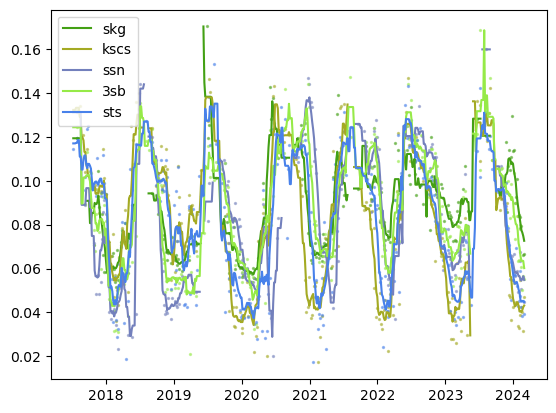

In [241]:
fig, ax = plt.subplots()
def plot_hls_timeseries(ax, var, reach, color): 
    df_smooth = hls_smooth.loc[(hls_smooth['variable'] == var) & 
                         (hls_smooth['reach'] == reach)]
    df = hls_agg.loc[(hls_agg['reach_name'] == reach)]

    ax.scatter(df['date'], df[var], s=2, alpha = 0.5, color = color)
    ax.plot(df_smooth['date'], df_smooth['value'],
            linewidth = 1.5,
            label = reach,
           color = color)
    
for reach, color in zip(reaches, colors): 
    plot_hls_timeseries(ax, 'green', reach, color)

ax.legend()
#ax.set_ylim(-1, 0.25)

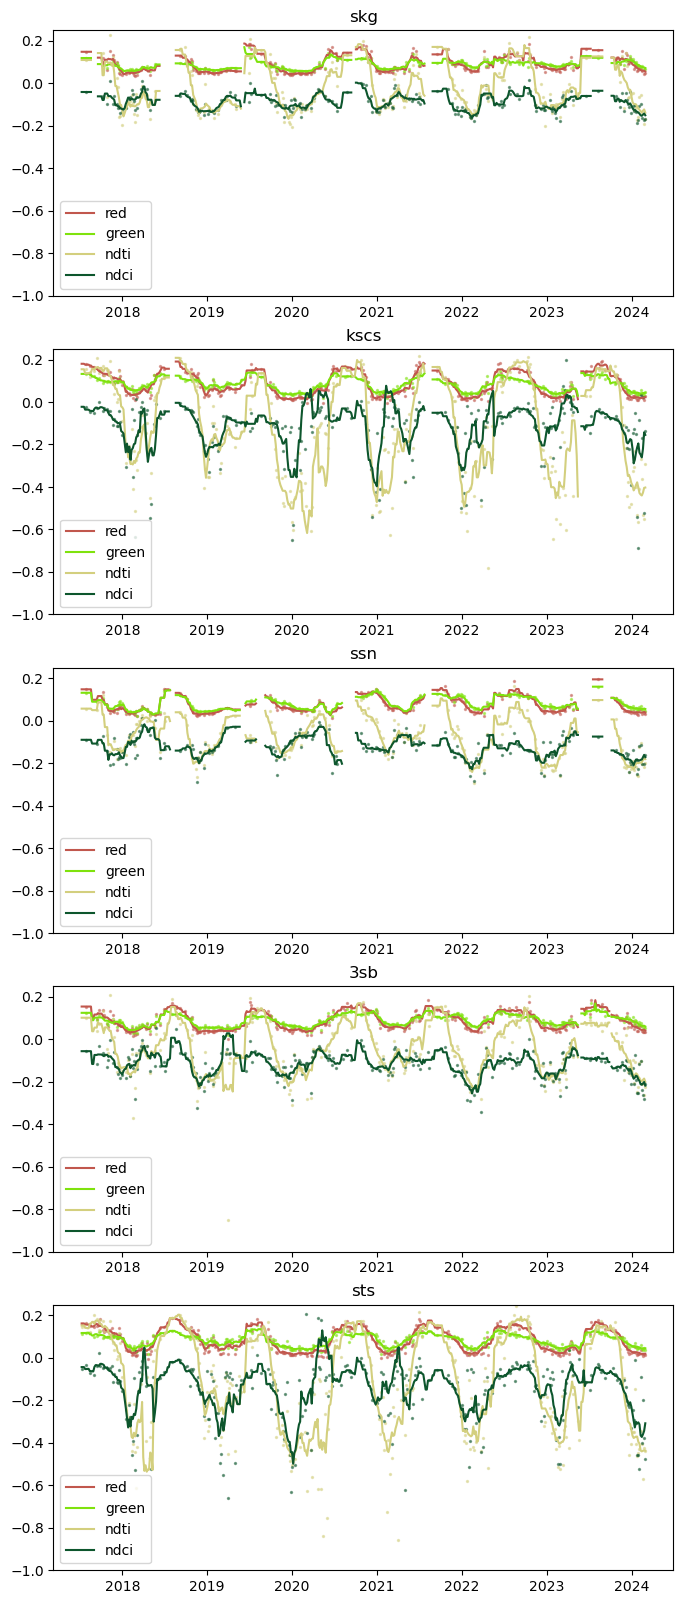

In [256]:
fig, ax = plt.subplots(5, 1, figsize=(8, 20))
def plot_hls_timeseries(ax, var, reach, color, label): 
    df_smooth = hls_smooth.loc[(hls_smooth['variable'] == var) & 
                         (hls_smooth['reach'] == reach)]
    df = hls_agg.loc[(hls_agg['reach_name'] == reach)]

    ax.scatter(df['date'], df[var], s=2, alpha = 0.5, color = color)
    ax.plot(df_smooth['date'], df_smooth['value'],
            linewidth = 1.5,
            label = label,
           color = color)

for i, reach in enumerate(reaches): 
    for var, color in zip(['red', 'green', 'ndti', 'ndci'], 
                          ['#c1574d', '#7fe20d', '#d3cf7e', '#0d562d']): 
        plot_hls_timeseries(ax[i], var, reach, color, var)
    ax[i].legend()
    ax[i].set_ylim(-1, 0.25)
    ax[i].set_title(reach)

